# Nanopore Signal Plotting with Remora

This notebook aims to introduce reading Nanopore signal data into Remora and visualizing this signal along with basecall or reference sequence assigned to the read.

#### Imports

In [1]:
from pathlib import Path

import pod5
import plotnine as p9

import remora
from remora import io

p9.theme_set(p9.theme_minimal() + p9.theme(figure_size=(10, 3)))

## POD5 and BAM Inputs

Remora consumes signal data from the POD5 file format output from Nanopore sequencing devices, and consumes basecalling/reference alignment information from industry standard BAM files.
Importantly, Remora parses the key tags along with the BAM format including move tables (alignment from basecalls to signal) and `MD` tags (references sequence storage).
The primary object for interacting with this information is the `remora.io.Read` object, commonly stored in an `io_read` variable.
The `io.Read` object contains a large number of functionalities for inspecting and manipulating the information from the signal, basecalls and reference alignment associated with a read.

The `remora.data_chunks.RemoraRead` object is a much smaller subset designed specifically to contain only the information required to extract training/inference chunks.

For example, the reference alignment information is removed when creating a `data_chunks.RemoraRead` object.
This allows for a simpler interface when running Remora models, but with much less functionality.
For inspection, the `io.Read` object is generally the correct object to use.

For the examples here we will load a small set of reads from the test data included with Remora.
These reads are the result of a PCR experiment and thus contain only canonical nucleotides.

In [2]:
test_data_root = Path("..") / "tests" / "data"
pod5_dr = pod5.DatasetReader(test_data_root)
bam_fh = io.ReadIndexedBam(test_data_root / "can_mappings.bam")

Indexing BAM by parent read id: 14 Reads [00:00, 7986.98 Reads/s]


An `io_read` object is generally constructed with the `io.Read.from_pod5_and_alignment` method.
This method takes in a `pod5.ReadRecord` and a `pysam.AlignedSegment` object from which relevant information is extracted.

In [3]:
read_id = "6e37823a-9398-4be8-b111-65cab029f4e0"
pod5_read = pod5_dr.get_read(read_id)
bam_read = bam_fh.get_first_alignment(read_id)
io_read = io.Read.from_pod5_and_alignment(pod5_read, bam_read)
print(f"Basecalls length: {io_read.seq_len}")
print(f"Reference mapping length: {io_read.ref_seq_len}")
print(f"Reference location: {io_read.ref_reg}")

Basecalls length: 6902
Reference mapping length: 6779
Reference location: RefRegion(ctg='chr13', strand='-', start=52303070, end=52309849)


## Basecall-anchored plotting

The `io_read` object allows extraction of sections of the read by indexing in base space.
Here the beginning and ending of the read are extracted.

In [4]:
start_of_basecalls = io_read.extract_basecall_region(end_base=50)
end_of_basecalls = io_read.extract_basecall_region(
    start_base=io_read.seq_len - 50
)

The returned `io.ReadBasecallRegion` object has limited functionality, primarily allowing a user to plot the signal and basecalls sequence.
Plotting can be performed in "base coordinates" or "signal coordinates".
Base coordinate plotting dilates signal such that the signal assigned to each base is fit into a single unit.
For base coordinate plotting, x-axis units are bases and signal is dilated to fit these coordinates.
Signal coordinate plotting equally spaces signal points, annotating bases where they appear.
In this plot signal points are evenly spaced and bases are annotated where they appear along the signal.

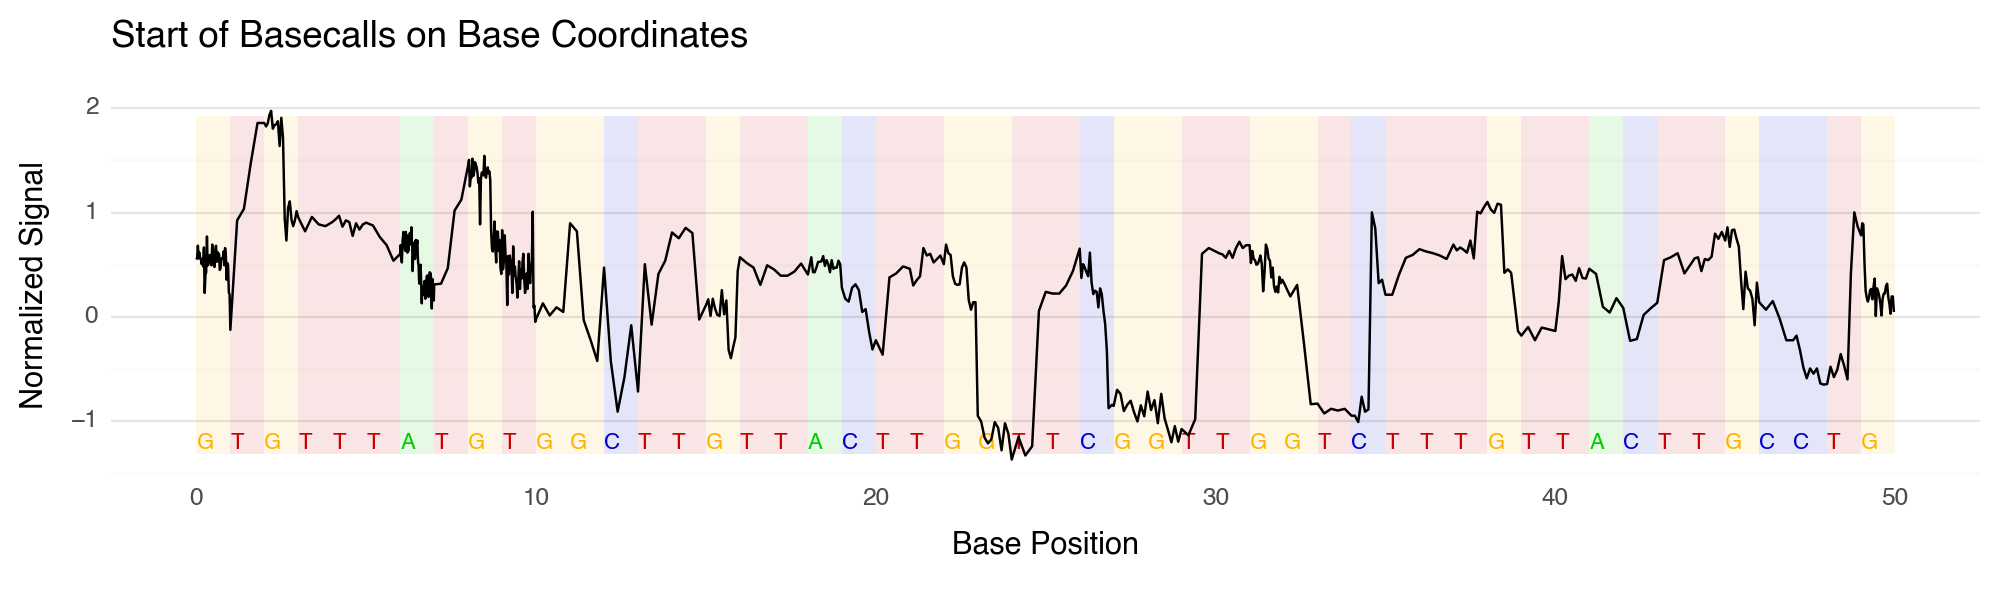

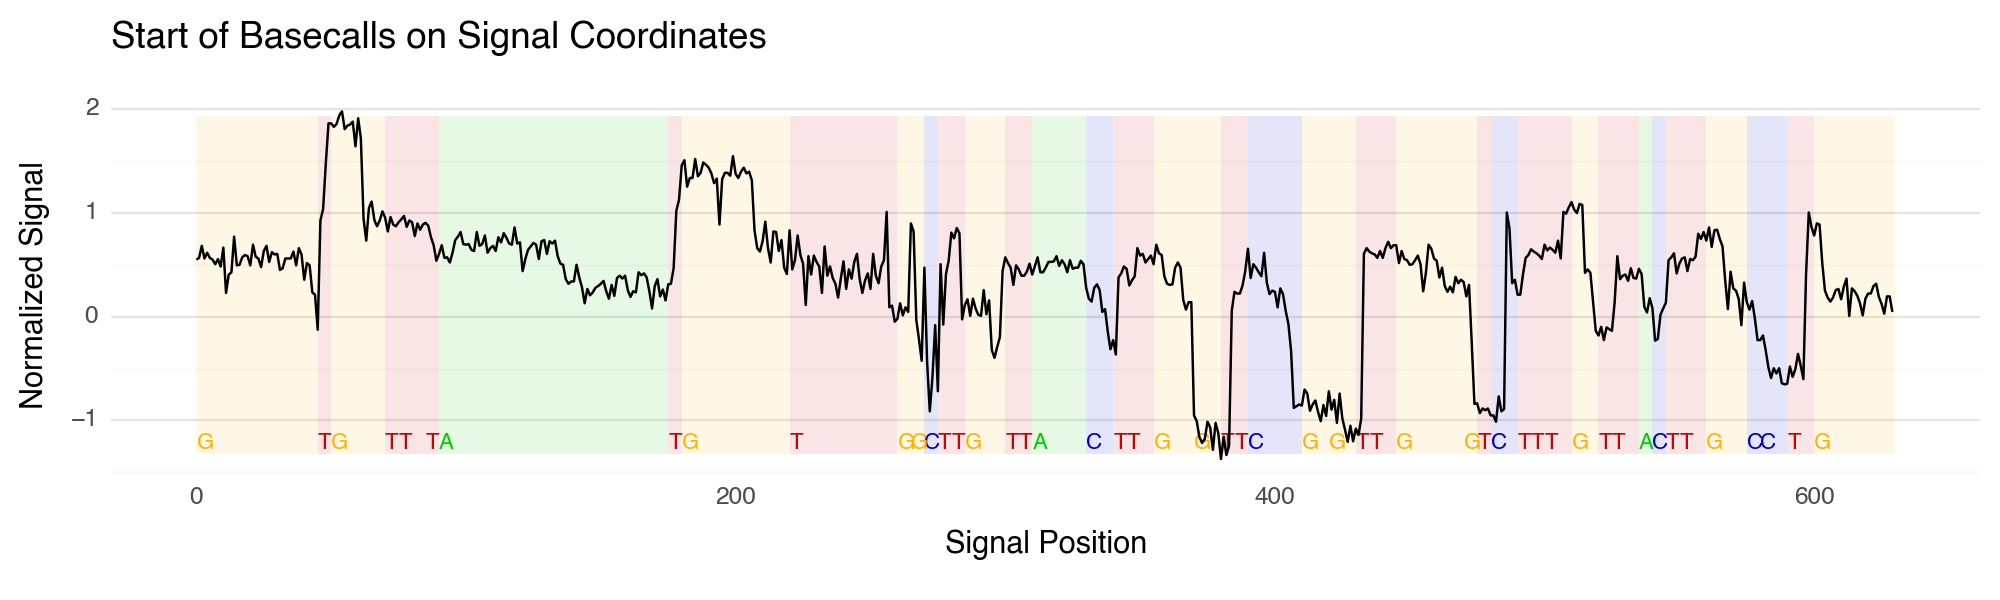

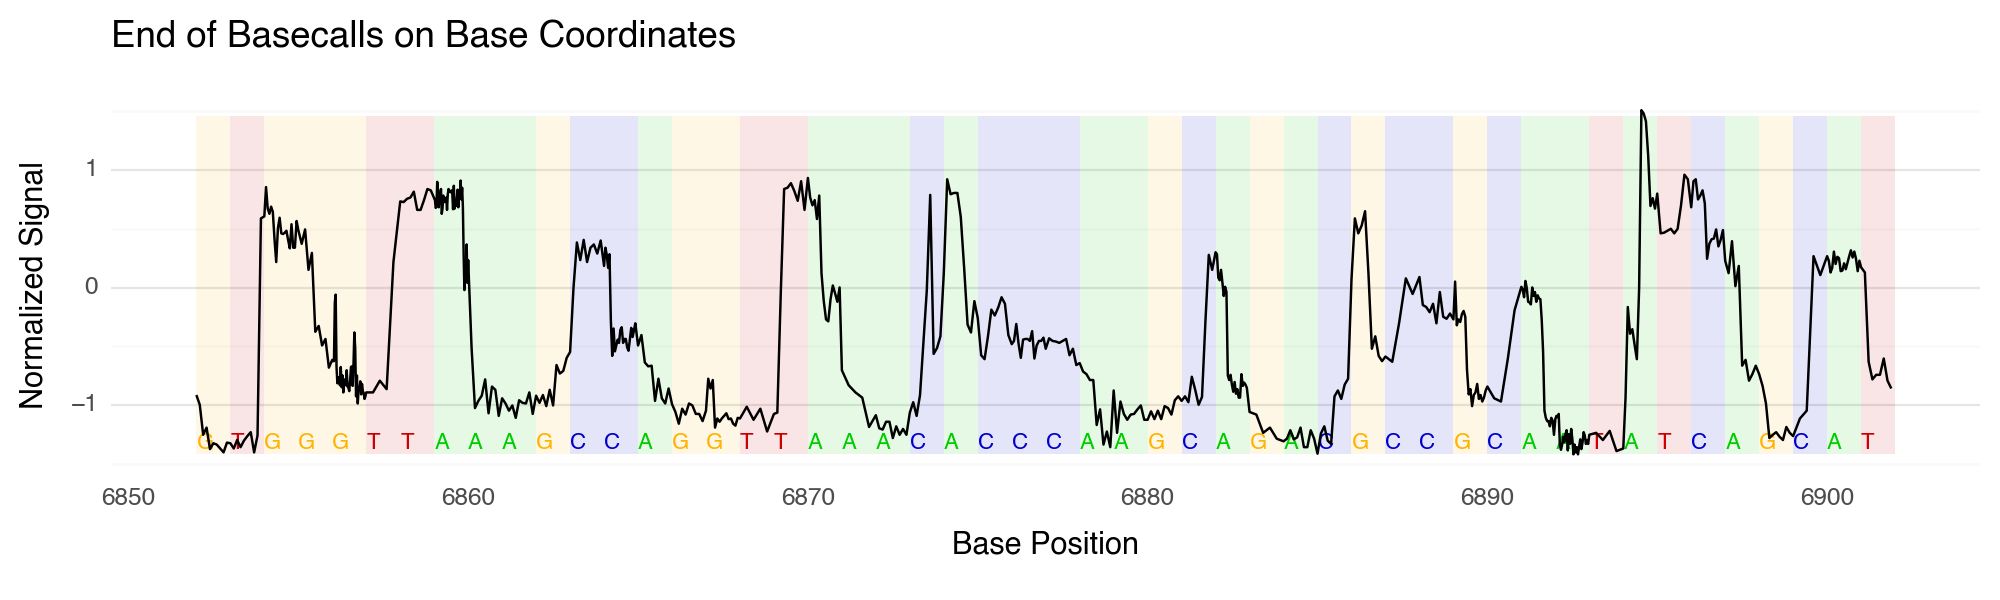

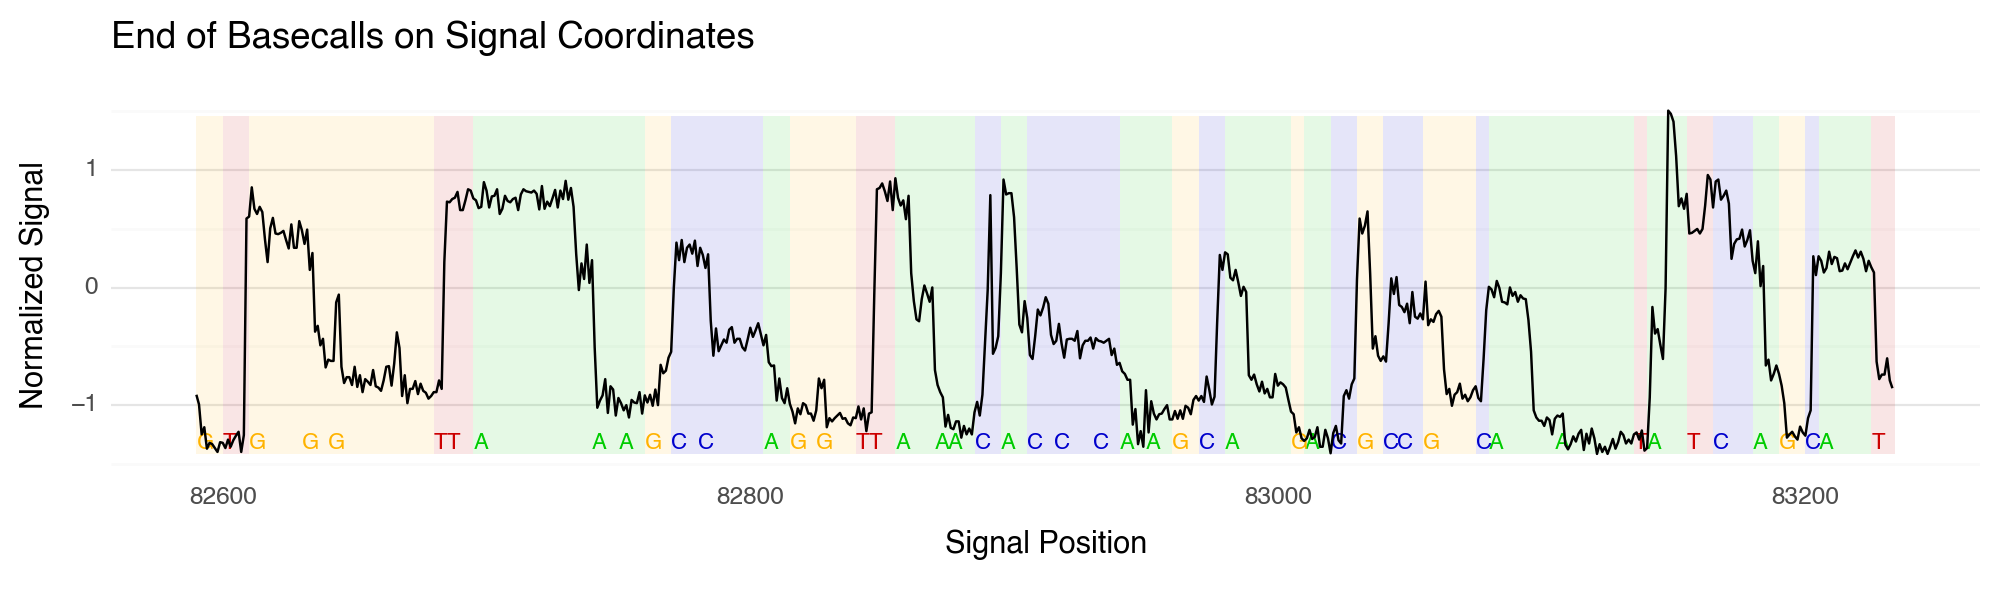

In [5]:
print(
    start_of_basecalls.plot_on_base_coords()
    + p9.ggtitle("Start of Basecalls on Base Coordinates")
)
print(
    start_of_basecalls.plot_on_signal_coords()
    + p9.ggtitle("Start of Basecalls on Signal Coordinates")
)
print(
    end_of_basecalls.plot_on_base_coords()
    + p9.ggtitle("End of Basecalls on Base Coordinates")
)
print(
    end_of_basecalls.plot_on_signal_coords()
    + p9.ggtitle("End of Basecalls on Signal Coordinates")
)

## Reference-anchored plotting

Similar to extracting sections of basecalls, Remora provides methods to extract sections of the reference alignment.
Here the beginning and end of the reference mapping are extracted into `io.ReadRefReg` objects.
Note that this is a reverse strand mapping read, so the beginning of the reference mapping is the end of the basecalls and vice versa.
The reference sequence shown is the reverse complement of the reference sequence.

Remora read objects generally store read-oriented data.
So for reverse strand mapping reads sequence is stored in the read-oriented 5' to 3' direction, keeping the signal in the natural orientation.

For Nanopore RNA reads which are sequenced from 3' to 5' the convention in Remora is to flip the signal as soon as possible after being extracted.
If initializing an `io.Read` object manually it is expected that the signal is flipped.
`io.Read` objects initialized with the `io.Read.from_pod5_and_alignment` method will perform the flipping assuming the `reverse_signal=True` option is set.

The data found in the `io.ReadRefReg` (returned from `io_read.extract_ref_reg` method) is reference-oriented.
So the `start_of_mapping.seq` is the complement of the reference region, the signal and `seq_to_sig_map` are in 3' to 5' orientation.
This allows the `io.ReadRefReg` to more easily combine information from multiple reads on a reference region, but care should be taken when interacting with the data from these objects.

In [6]:
start_of_mapping = io_read.extract_ref_reg(
    io_read.ref_reg.adjust(end_adjust=50 - io_read.ref_reg.len)
)
end_of_mapping = io_read.extract_ref_reg(
    io_read.ref_reg.adjust(start_adjust=io_read.ref_reg.len - 50)
)

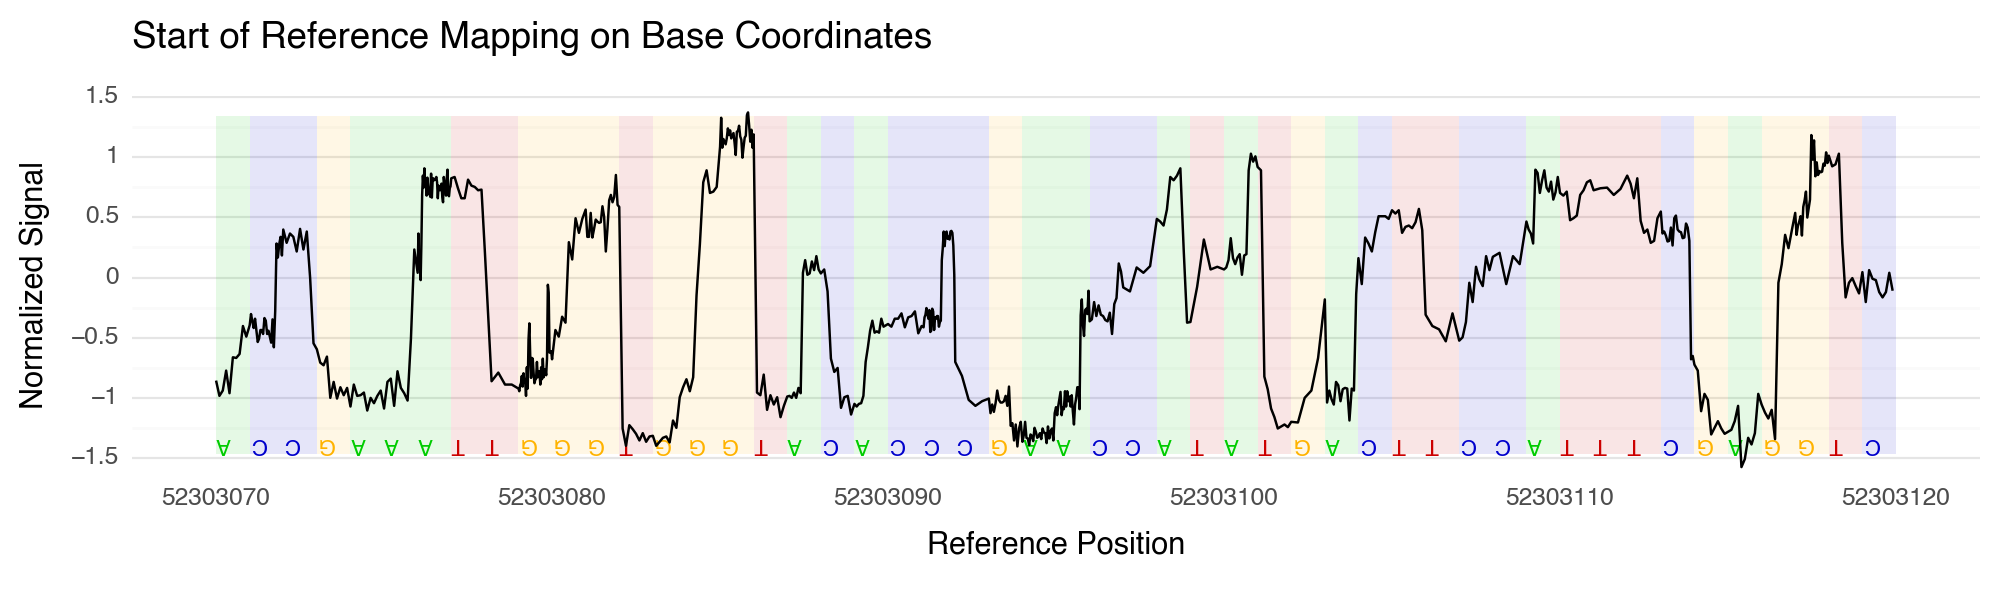

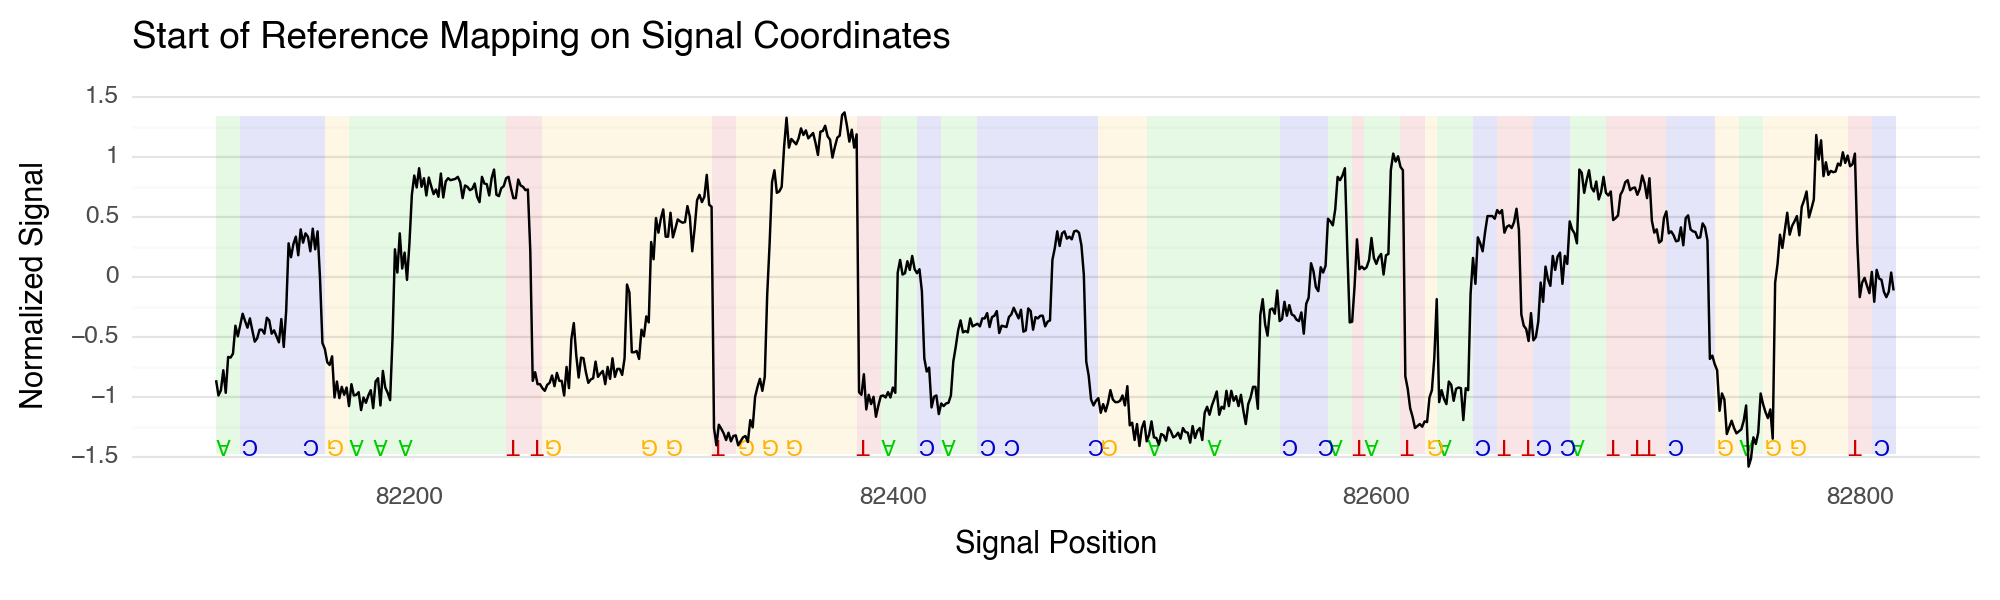

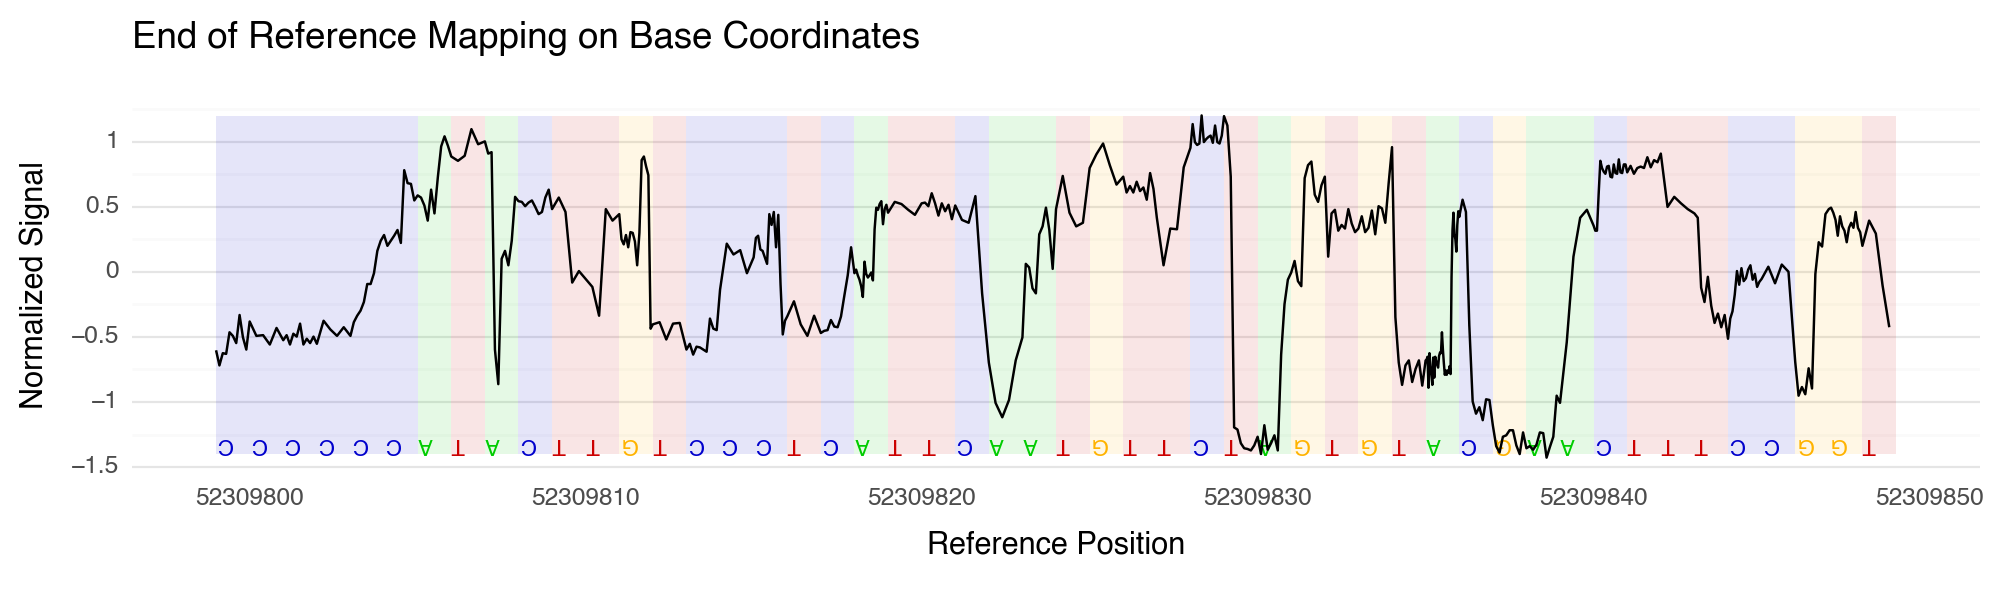

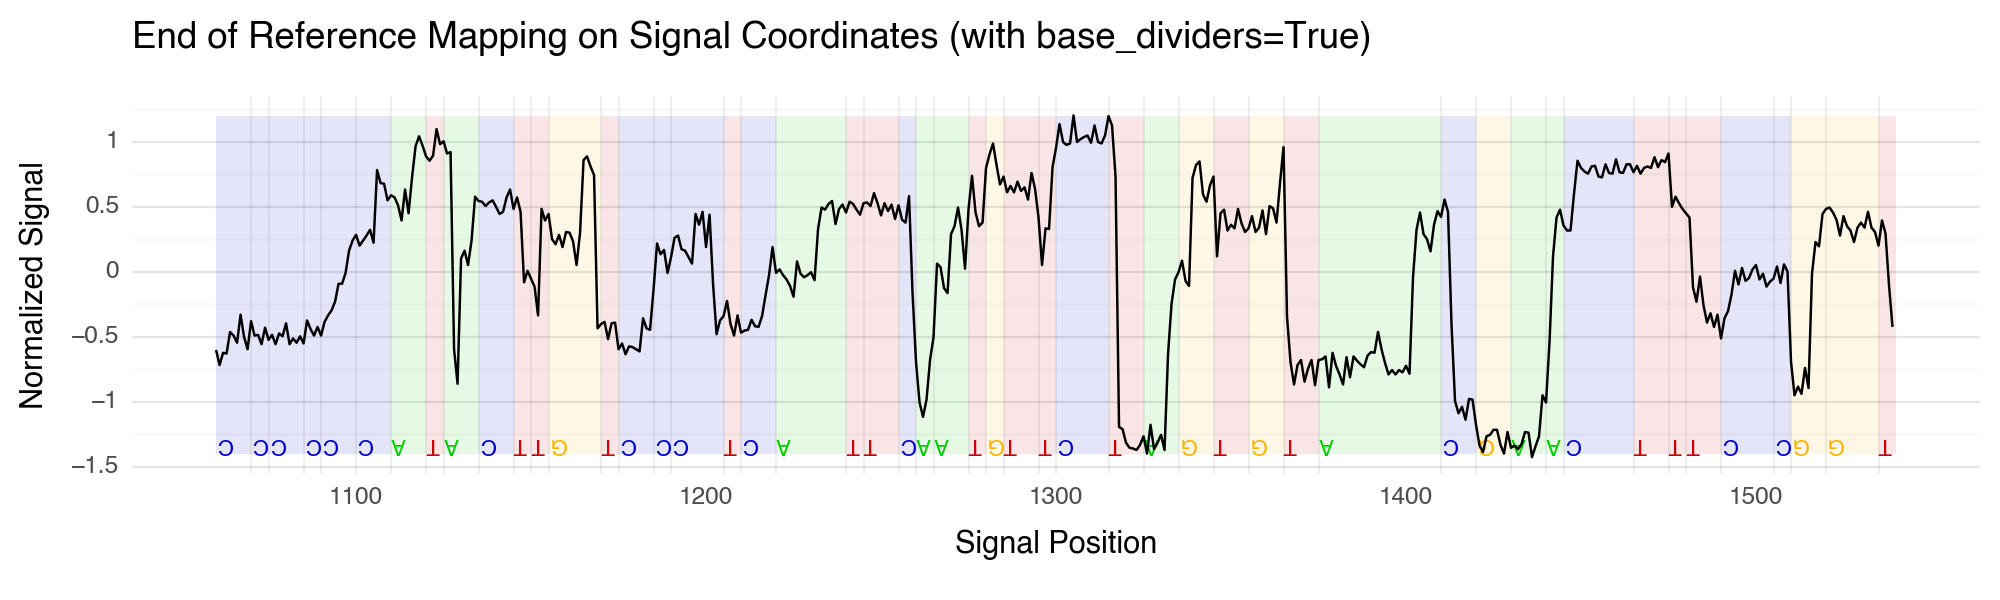

In [7]:
print(
    start_of_mapping.plot_on_base_coords()
    + p9.ggtitle("Start of Reference Mapping on Base Coordinates")
)
print(
    start_of_mapping.plot_on_signal_coords()
    + p9.ggtitle("Start of Reference Mapping on Signal Coordinates")
)
print(
    end_of_mapping.plot_on_base_coords()
    + p9.ggtitle("End of Reference Mapping on Base Coordinates")
)
print(
    end_of_mapping.plot_on_signal_coords(base_dividers=True)
    + p9.ggtitle(
        "End of Reference Mapping on Signal Coordinates (with base_dividers=True)"
    )
)

To extract the reference sequence to signal mappings in the above plots the `io_read.ref_seq` and `io_read.ref_to_signal` attributes can be used.
For basecall-anchored mappings the `io_read.seq` and `io_read.query_to_signal` attributes can be used.
The Nth element of the `*_to_signal` attributes give the coordinate in the signal array at which the Nth base starts.
Note that trimmed signal is not included in the `*_to_signal` arrays.
This includes trimmed signal (annotated in the `ts` BAM tag from Nanopore basecallers) in the `query_to_signal` arrays and soft-clipped bases in the `ref_to_signal` array.

## Plot Reference Alignment with Signal Overlay

One final basic plot type of interest is reference alignment with signal overlay.
In this plot basecalls are shown on the top and reference bases on the top.
In the first plot, we can see the start of the reference mapping with soft-clipped basecalls showing no corresponding reference bases.
In the second plot we can see a stretch of lower accuracy displaying several mapping errors.

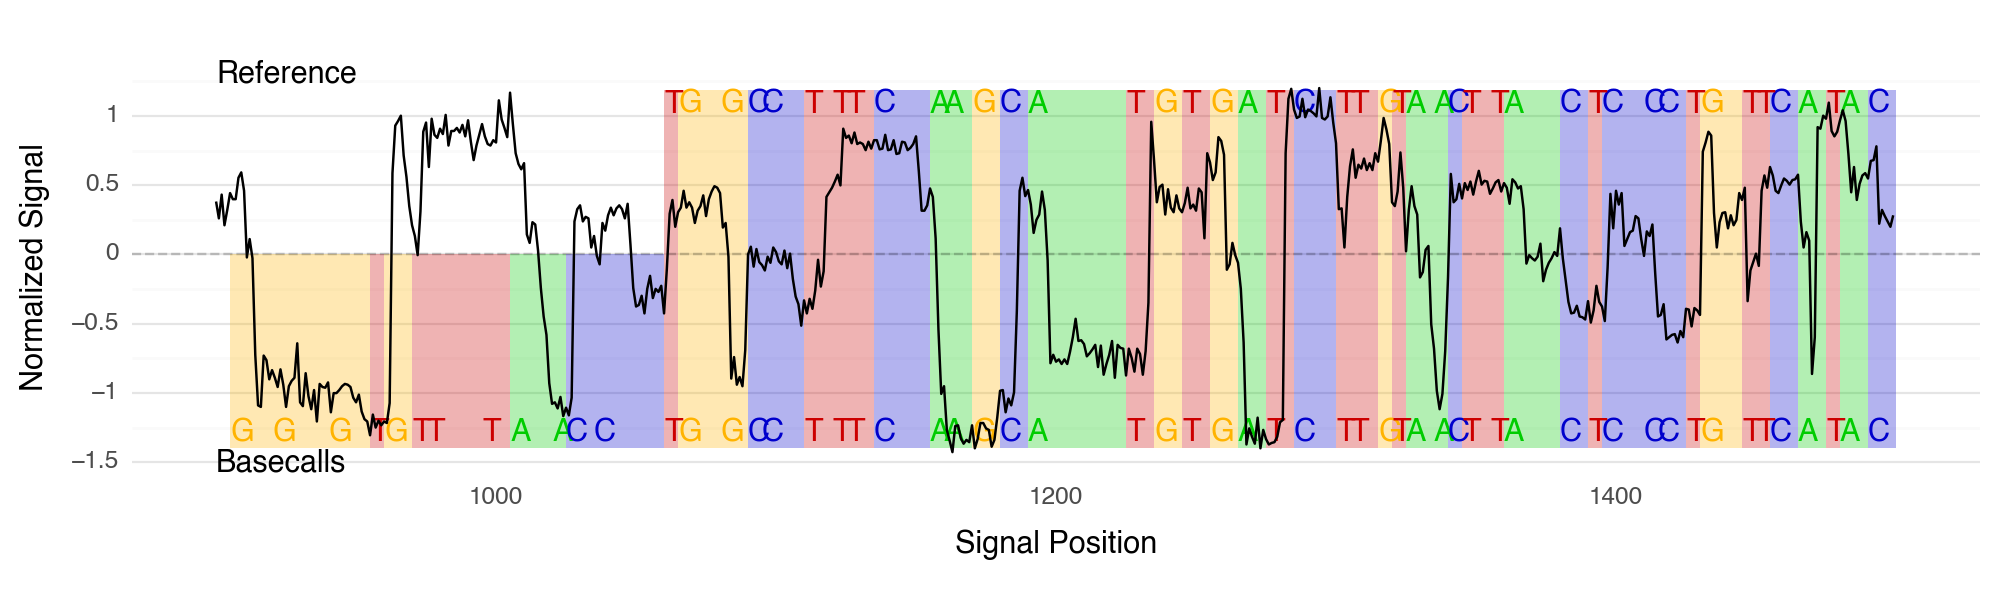

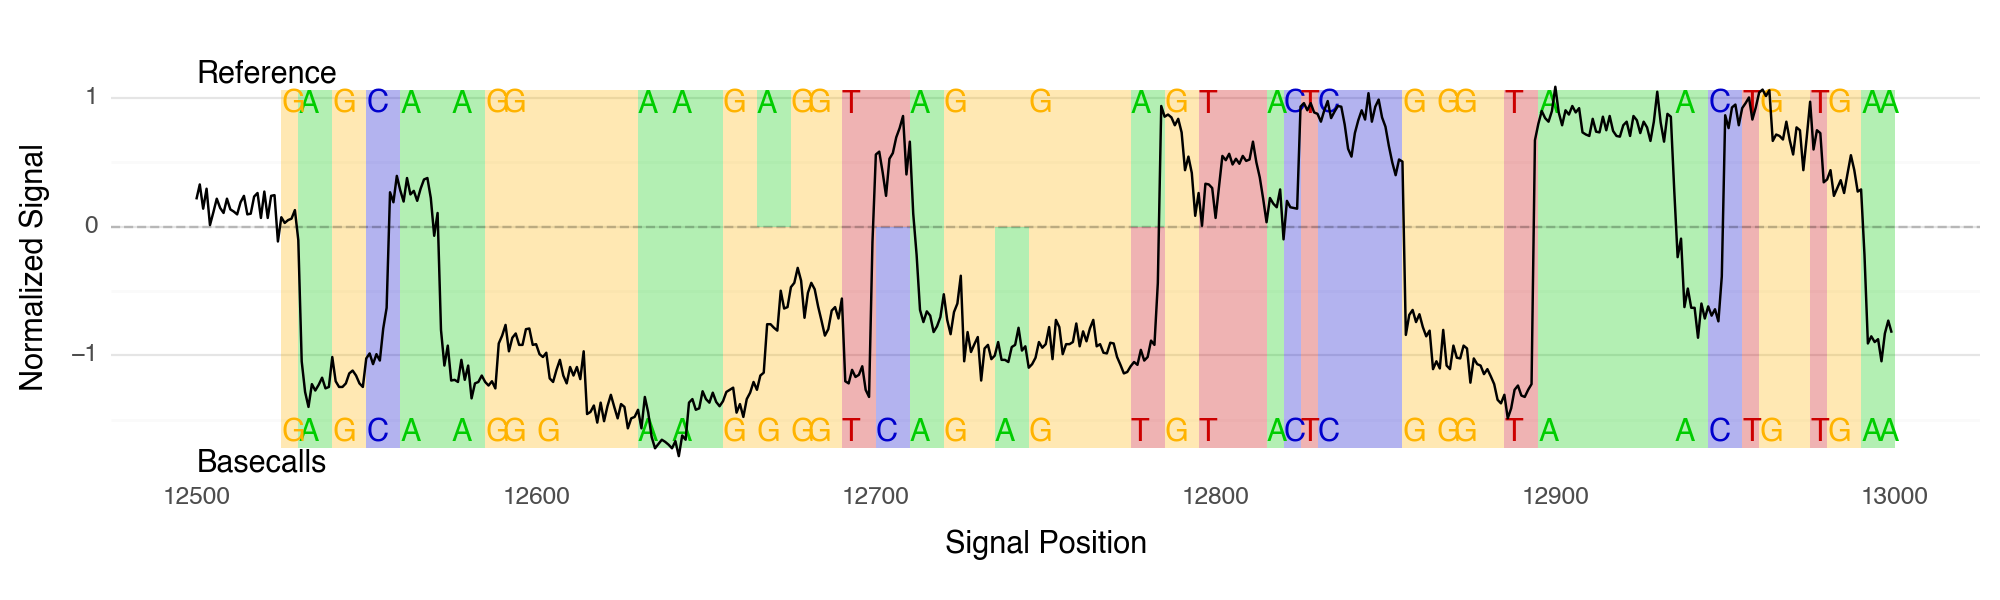

In [8]:
print(io.plot_align(io_read, 900, 1500))
print(io.plot_align(io_read, 12_500, 13_000))

For more advanced signal plotting, see the `signal_mapping_refinement.ipynb` and `metrics_api.ipynb` notebooks.